# Explore data to evaluate if Classification of N delivery time bins works
- Regression approaches have led to crappy models due to made features. (More information in the future may change this)
- Explore if classification will work. 
    - Wait times apart from noise vary from [0, 120 minutes]
    - Let's assume that we have an error tolerance parameter of e minutes. For example we have decided that it is okay to be off by 5 minutes
    - We chop the predict variable range into time bins (categories) that are 5 minutes long and convert this into a classification task
    - We predict to the customer given the input feature vector what is the estimated time frame we can expect their food: 0 - 5 minutes, 5 - 10 minutes, 20 - 25 minutes, 90 - 95 minutes.
    - Caveats: We do not know the impact of a wrong class prediction. How off are we if we get a time bin prediction wrong?
    - The goal of the work in this notebook is to evaluate if the features are strong enough to support a classification task

In [52]:
# read data
import os
import pandas as pd
DATA_READ_PATH = '/Users/calvinperumalla/personal project/Master - Data Scientist, ML Project 6'
DATA_FILE = 'historical_data.csv'
train_data_unfiltered = pd.read_csv(os.path.join(DATA_READ_PATH,DATA_FILE))

In [53]:
# read feature description and load into a dictionary for easy look up ;)
feature_description = pd.read_csv(os.path.join(DATA_READ_PATH, 'feature_description.csv'))[['feature', 'description']].drop_duplicates(subset='feature').to_dict()
index = list(feature_description['description'].keys())
feature_description = {feature_description['feature'][i]:feature_description['description'][i] for i in index}

In [54]:
len(feature_description)

16

In [55]:
import datetime
train_data_unfiltered['pick_up_time'] = (pd.to_datetime(train_data_unfiltered['actual_delivery_time']) - pd.to_datetime(train_data_unfiltered['created_at']))
train_data_unfiltered['pick_up_time'] = train_data_unfiltered['pick_up_time'].apply(lambda x: x.total_seconds()) - train_data_unfiltered['estimated_order_place_duration'] - train_data_unfiltered['estimated_store_to_consumer_driving_duration']

In [56]:
# to remove noise
import numpy as np
from tqdm import tqdm
def filter_noise(df, features, noise_threshold=99):
    tmp_df = None
    for f in tqdm(features):
        if tmp_df is None:
            tmp_df = df
        upper = np.percentile(tmp_df[f], noise_threshold)
        tmp_df = tmp_df[tmp_df[f]< upper]
    return tmp_df

In [57]:
print('full size: {}'.format(len(train_data_unfiltered)))
train_data_unfiltered = train_data_unfiltered.dropna(subset=['pick_up_time'])
train_data_unfiltered = train_data_unfiltered[train_data_unfiltered['pick_up_time']>0]
print('after removing noise: {}'.format(len(train_data_unfiltered)))
train_data_unfiltered.fillna(0, inplace=True)

full size: 197428
after removing noise: 196829


In [58]:
# Make Pick up time category
train_data = filter_noise(train_data_unfiltered, ['pick_up_time'])
num_bins = 5
bin_size = (max(train_data['pick_up_time'])/num_bins) + 1
train_data['pick_up_time_bin'] = (train_data['pick_up_time']/bin_size).astype(int)

100%|██████████| 1/1 [00:00<00:00, 43.70it/s]
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [77]:
train_data.dtypes

market_id                                       float64
store_id                                          int64
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
pick_up_time                                    float64
pick_up_time_bin                                  int64
store_primary_encoded                             int64
dtype: object

In [59]:
from matplotlib import pyplot as plt
import numpy as np
def get_bins(series, thresh=99.99, num_bins=20):
    noise_bins = 4
    noise_above = int(np.percentile(series, thresh))
    upper = int(np.max(series))
    bins_lower = list(range(0,noise_above,int(noise_above/(num_bins-noise_bins))))
    #noise_ranges = list(range(noise_above, upper, int((upper-noise_above)/4)))
    return bins_lower
    
def plot_hist(df, features, bin_dict=None):
    bins = bin_dict
    num_features = len(features)
    print('plotting {} plots'.format(num_features))
    if num_features == 1:
        f = plt.hist(df[features[0]], bins=get_bins(df[features[0]]))
        #f = plt.hist(df[features[0]])
        plt.title('histogram of {}'.format(features[0]))
        plt.xlabel(features[0])
        plt.show()
        return
    if num_features == 2:
        plt.figure(figsize=(10, 10))
        plt.subplot(1,2,1)
        f = plt.hist(df[features[0]], bins=get_bins(df[features[0]]))
        plt.title('histogram of {}'.format(features[0]))
        plt.xlabel(features[0])

        plt.subplot(1,2,2)
        f = plt.hist(df[features[1]], bins=get_bins(df[features[1]]))
        plt.title('histogram of {}'.format(features[1]))
        plt.xlabel(features[1])
        plt.show()
        plt.subplots_adjust(bottom=0.1, right=1.2)
        return
    if num_features%3 == 0:
        num_rows = int(num_features/3)
    else:
        num_rows = int(num_features/3) + 1
    fig, axes = plt.subplots(nrows=num_rows, ncols=3)
    fig.subplots_adjust(left=2, right=3)
    fig.set_size_inches(20, 10)
    for ax, index in zip(axes.flatten(), range(len(features))):
        ax.hist(df[features[index]], bins=get_bins(df[features[index]]))
        ax.set(title = 'histogram of {}'.format(features[index]), xlabel=features[index])

In [60]:
def plot_correlation(df, features):
    num_features = len(features)
    print('plotting {} plots'.format(num_features))
    if num_features == 1:
        f = plt.scatter(df[features[0]], df['pick_up_time'])
        #f = plt.hist(df[features[0]])
        plt.title('correlation of {} with pick up time'.format(features[0]))
        plt.xlabel(features[0])
        plt.show()
        return
    if num_features == 2:
        f = plt.scatter(df[features[0]], df['pick_up_time'])
        #f = plt.hist(df[features[0]])
        plt.title('correlation of {} with pick up time'.format(features[0]))
        plt.xlabel(features[0])
        plt.show()

        plt.subplot(1,2,2)
        f = plt.scatter(df[features[1]], df['pick_up_time'])
        #f = plt.hist(df[features[0]])
        plt.title('correlation of {} with pick up time'.format(features[1]))
        plt.xlabel(features[1])
        plt.show()
        #plt.subplots_adjust(bottom=0.1, right=1.2)
        return
    if num_features%3 == 0:
        num_rows = int(num_features/3)
    else:
        num_rows = int(num_features/3) + 1
    fig, axes = plt.subplots(nrows=num_rows, ncols=3)
    fig.subplots_adjust(left=2, right=3)
    fig.set_size_inches(20, 10)
    for ax, index in zip(axes.flatten(), range(len(features))):
        ax.scatter(df[features[index]], df['pick_up_time'])
        ax.set(title = 'correlation of {} with pick up time'.format(features[index]), xlabel=features[index])

In [61]:
from collections import Counter
Counter(train_data['pick_up_time_bin'])

Counter({0: 35045, 1: 96316, 2: 45873, 3: 13741, 4: 3884})

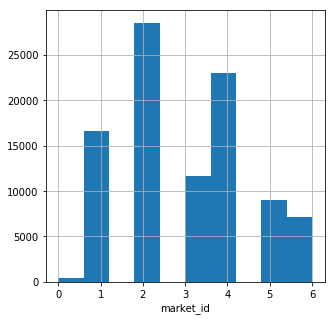

In [62]:
train_data = train_data.fillna(value=0)
# quick delivery
quick_bin = train_data[train_data['pick_up_time_bin']==1]

# late delivery
late_bin = train_data[train_data['pick_up_time_bin']==2]

from matplotlib import pyplot as plt
feature = 'market_id'
plt.figure(figsize=(5, 5))
plt.hist(quick_bin[feature])
plt.xlabel(feature)
plt.grid()
plt.show()

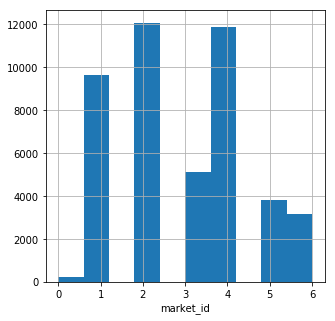

In [63]:
plt.figure(figsize=(5, 5))
plt.hist(late_bin[feature])
plt.xlabel(feature)
plt.grid()
plt.show()

## Approach: Random forest
- Throw all features at it and see what happens

In [64]:
train_data = train_data.drop(labels=['actual_delivery_time', 'created_at'], axis=1)
train_data['store_primary_category'] = train_data['store_primary_category'].astype('category')
train_data.dtypes

market_id                                        float64
store_id                                           int64
store_primary_category                          category
order_protocol                                   float64
total_items                                        int64
subtotal                                           int64
num_distinct_items                                 int64
min_item_price                                     int64
max_item_price                                     int64
total_onshift_dashers                            float64
total_busy_dashers                               float64
total_outstanding_orders                         float64
estimated_order_place_duration                     int64
estimated_store_to_consumer_driving_duration     float64
pick_up_time                                     float64
pick_up_time_bin                                   int64
dtype: object

In [65]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_data['store_primary_category'])
train_data['store_primary_encoded'] = le.transform(train_data['store_primary_category'])
train_data = train_data.drop('store_primary_category', axis=1)

In [66]:
type(train_data)

pandas.core.frame.DataFrame

In [15]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

kfold = KFold(n_splits=5)
model_predictions = {}
model_performance = {}
model_run_index = 0
X = train_data.drop(['pick_up_time', 'pick_up_time_bin'], axis=1)
y = train_data[['pick_up_time_bin']]
rand_forest = RandomForestClassifier()
for train_index, test_index in tqdm(kfold.split(X)):
    model_run_index += 1
    train_x = X.iloc[train_index]
    train_y = y.iloc[train_index]
    #print(any([any(np.isnan(inst)) for inst in train_x]))
    #print(any([np.isnan(inst) for inst in train_y]), 'y')
    model = rand_forest.fit(train_x, train_y)
    test_x = X.iloc[test_index]
    test_y = y.iloc[test_index]
    predictions = model.predict(test_x)
    model_name = 'run_{}'.format(model_run_index)
    model_predictions[model_name] = zip(test_y.values, predictions)
    model_performance[model_name] = model.score(test_x, test_y)

0it [00:00, ?it/s]/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
5it [00:18,  3.76s/it]


In [16]:
# r2 score 
model_performance

{'run_1': 0.45712306271169045,
 'run_2': 0.4614338499435492,
 'run_3': 0.46110027712203633,
 'run_4': 0.46340962742481784,
 'run_5': 0.4611121090041313}

In [17]:
total = 0
mispredicitions = []
for true, pred in model_predictions['run_5']:
    total += 1
    if true != pred:
        mispredicitions.append(true-pred)
        
        
print('bin size in minutes: {}'.format(bin_size/60.0))
print('total_accuracy: {}'.format(1.0*(total - len(mispredicitions))/total))
print('total predictions {}'.format(total))
print('total number of mis predictions: {}'.format(len(mispredicitions)))
mis_np = np.array(mispredicitions)
early = mis_np[mis_np>0]
late = mis_np[mis_np<0]
print('total number of early mispredictions:{}'.format(len(early)))
print('total number of late mispredictions:{}'.format(len(late)))
early_avg = sum(early)/len(early) * (bin_size * 1/60.0) 
late_avg = -1* (sum(late)/len(late) * (bin_size * 1/60.0))
print('avg error in early errors: {} minutes'.format(early_avg))
print('avg error in late errors: {} minutes'.format(late_avg))

bin size in minutes: 18.53
total_accuracy: 0.461112109004
total predictions 38971
total number of mis predictions: 21001
total number of early mispredictions:12939
total number of late mispredictions:8062
avg error in early errors: 18.53 minutes
avg error in late errors: 37.06 minutes


In [18]:
zip(model.feature_importances_, X.columns)

[(0.028653350631821645, 'market_id'),
 (0.09804357698874484, 'store_id'),
 (0.031986517885318325, 'order_protocol'),
 (0.03280598791408395, 'total_items'),
 (0.11793343977198438, 'subtotal'),
 (0.029462322009389176, 'num_distinct_items'),
 (0.09433356453704148, 'min_item_price'),
 (0.09506554966252886, 'max_item_price'),
 (0.08835460577958858, 'total_onshift_dashers'),
 (0.08123466909651901, 'total_busy_dashers'),
 (0.10330707859020598, 'total_outstanding_orders'),
 (0.00968171552115548, 'estimated_order_place_duration'),
 (0.11971750216629959, 'estimated_store_to_consumer_driving_duration'),
 (0.06942011944531867, 'store_primary_encoded')]

## Approach: Neural Network


In [19]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(alpha=1e-5, activation='logistic', hidden_layer_sizes=(100, 3))

In [20]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

kfold = KFold(n_splits=5)
model_predictions = {}
model_performance = {}
model_run_index = 0
X = train_data.drop(['pick_up_time', 'pick_up_time_bin'], axis=1)
y = train_data[['pick_up_time_bin']]
rand_forest = RandomForestClassifier()
for train_index, test_index in tqdm(kfold.split(X)):
    model_run_index += 1
    train_x = X.iloc[train_index]
    train_y = y.iloc[train_index]
    #print(any([any(np.isnan(inst)) for inst in train_x]))
    #print(any([np.isnan(inst) for inst in train_y]), 'y')
    model = clf.fit(train_x, train_y)
    test_x = X.iloc[test_index]
    test_y = y.iloc[test_index]
    predictions = model.predict(test_x)
    model_name = 'run_{}'.format(model_run_index)
    model_predictions[model_name] = zip(test_y.values, predictions)
    model_performance[model_name] = model.score(test_x, test_y)

0it [00:00, ?it/s]/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
5it [02:05, 25.04s/it]


In [21]:
# r2 score 
model_performance

{'run_1': 0.500076978343426,
 'run_2': 0.49910191932669606,
 'run_3': 0.49828081699681825,
 'run_4': 0.5040028738581546,
 'run_5': 0.4995252880346925}

In [22]:
total = 0
mispredicitions = []
for true, pred in model_predictions['run_5']:
    total += 1
    if true != pred:
        mispredicitions.append(true-pred)
        
        
print('bin size in minutes: {}'.format(bin_size/60.0))
print('total_accuracy: {}'.format(1.0*(total - len(mispredicitions))/total))
print('total predictions {}'.format(total))
print('total number of mis predictions: {}'.format(len(mispredicitions)))
mis_np = np.array(mispredicitions)
early = mis_np[mis_np>0]
late = mis_np[mis_np<0]
print('total number of early mispredictions:{}'.format(len(early)))
print('total number of late mispredictions:{}'.format(len(late)))
early_avg = sum(early)/len(early) * (bin_size * 1/60.0) 
late_avg = -1* (sum(late)/len(late) * (bin_size * 1/60.0))
print('avg error in early errors: {} minutes'.format(early_avg))
print('avg error in late errors: {} minutes'.format(late_avg))

bin size in minutes: 18.53
total_accuracy: 0.499525288035
total predictions 38971
total number of mis predictions: 19504
total number of early mispredictions:11077
total number of late mispredictions:8427
avg error in early errors: 18.53 minutes
avg error in late errors: 37.06 minutes


In [23]:
train_data.dtypes

market_id                                       float64
store_id                                          int64
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
pick_up_time                                    float64
pick_up_time_bin                                  int64
store_primary_encoded                             int64
dtype: object

# PREDICTION ON UNSEEN TEST SET

In [67]:
PREDICT_FILE = 'predict_data.csv'
predict_set = pd.read_csv(os.path.join(DATA_READ_PATH, PREDICT_FILE))

In [28]:
predict_set.dtypes

market_id                                       float64
created_at                                       object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
delivery_id                                       int64
platform                                         object
dtype: object

In [79]:
# drop un related features
features_df = predict_set.drop(['created_at', 'delivery_id', 'platform'], axis=1)
features_df = features_df.fillna(value=0)
features_df['store_primary_encoded'] = le.transform(features_df['store_primary_category'])
features_df = features_df.drop('store_primary_category', axis=1)

In [101]:
features_np = np.array(features_df)

In [102]:
predictions = model.predict(features_np)

In [113]:
predictions_second = (predictions + 1) * 1111.8

In [122]:
from datetime import timedelta
predict_set['predicted_delivery_time'] = pd.to_datetime(predict_set['created_at']) + map(lambda x: timedelta(seconds=x), predictions_second)

In [125]:
predict_set.to_csv(os.path.join(DATA_READ_PATH, 'predictions.csv'))